Alibaba cluster trace v2017
Workload pods + Cluster nodes

Working with modified traces.

In [10]:
import pandas as pd
colnames=['timestamp', 'machine_id', 'event_type', 'event_detail', 'number_of_cpus', 'normalized_memory', 'normalized_disk_space'] 
machine_events = pd.read_csv('server_event_add_only.csv', names=colnames, header=None)
machine_events.describe()

,timestamp,machine_id,event_detail,number_of_cpus,normalized_memory,normalized_disk_space
count,1313.0,1313.000000,0.0,1313.0,1313.000000,1313.000000
mean,0.0,657.000000,NaN,64.0,0.692729,0.999286
std,0.0,379.174762,NaN,0.0,0.029690,0.024972
min,0.0,1.000000,NaN,64.0,0.574788,0.095725
25%,0.0,329.000000,NaN,64.0,0.689970,1.000000
50%,0.0,657.000000,NaN,64.0,0.689970,1.000000
75%,0.0,985.000000,NaN,64.0,0.690001,1.000000
max,0.0,1313.000000,NaN,64.0,1.000000,1.000000


In [11]:
colnames=['task_create_time', 'task_end_time', 'job_id', 'task_id', 'number_of_instances', 'status', 'number_of_cpus_requested_per_instance_in_the_task', 'normalized_memory_requested_per_instance_in_the_task'] 
batch_tasks = pd.read_csv('batch_task_fit_only.csv', names=colnames, header=None)
batch_tasks.describe()

,task_create_time,task_end_time,job_id,task_id,number_of_instances,number_of_cpus_requested_per_instance_in_the_task,normalized_memory_requested_per_instance_in_the_task
count,53472.000000,53472.000000,53472.000000,53472.000000,53472.000000,53472.000000,53472.000000
mean,33978.867968,34171.588813,6527.972771,40369.946701,160.575067,49.956239,0.007813
std,17210.269129,17160.988692,3609.399784,22767.591623,924.179485,0.945956,0.004554
min,-849.000000,-843.000000,2.000000,2.000000,1.000000,40.000000,0.003815
25%,18968.000000,19726.000000,3787.250000,22596.750000,1.000000,50.000000,0.004110
50%,40447.000000,40577.500000,6846.000000,40529.000000,2.000000,50.000000,0.007941
75%,48350.000000,48426.000000,9017.000000,59288.250000,71.000000,50.000000,0.009334
max,59656.000000,61668.000000,12951.000000,80553.000000,64486.000000,60.000000,0.127332


<Axes: xlabel='timestamp'>

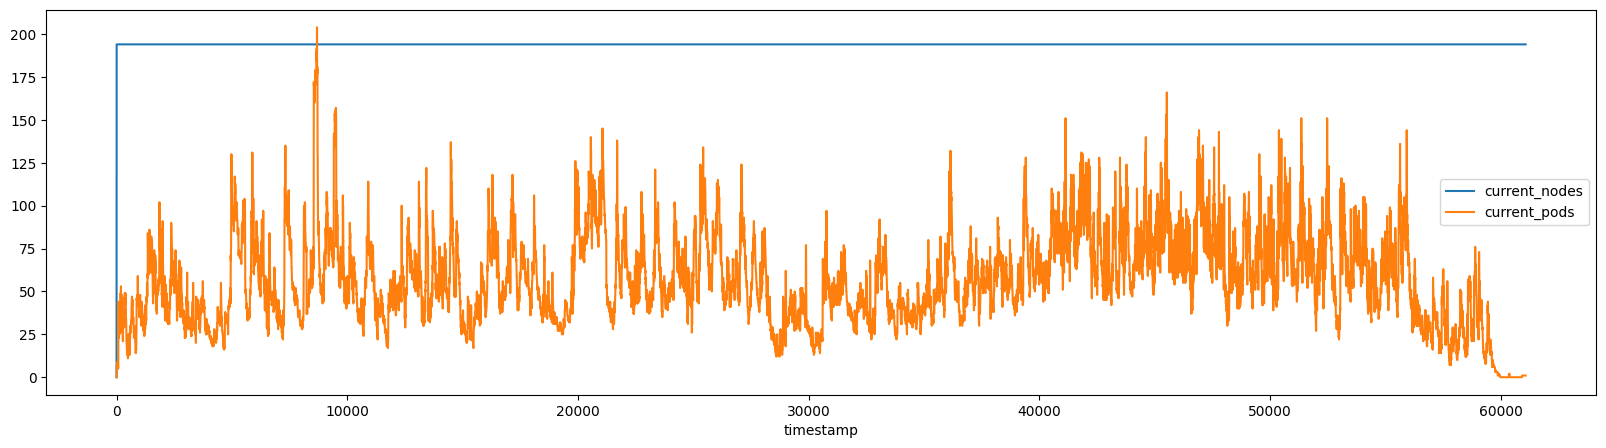

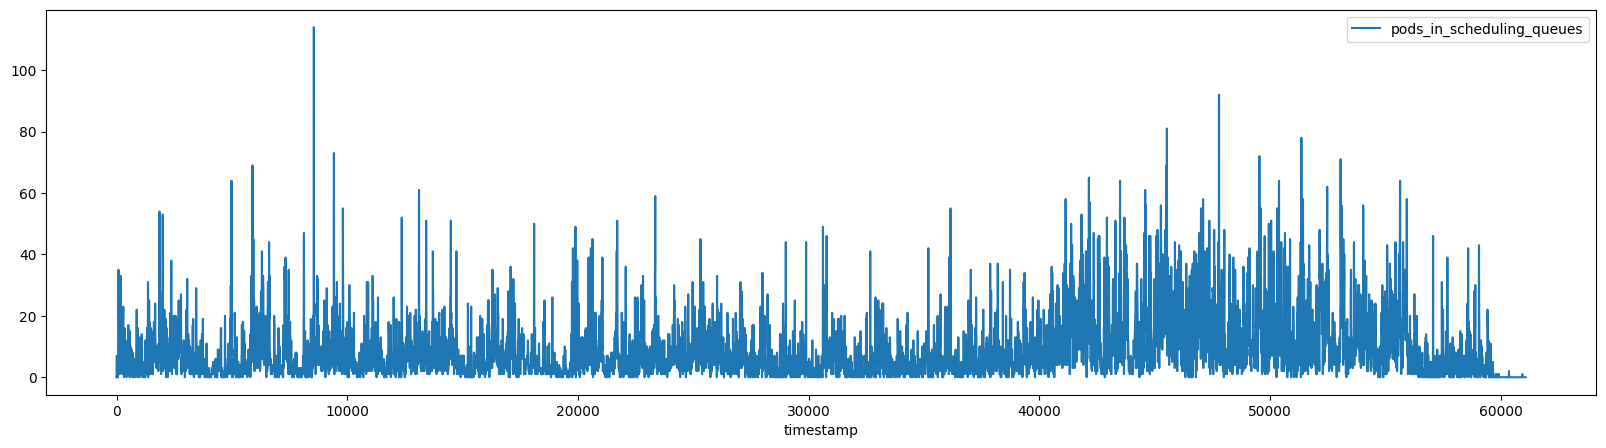

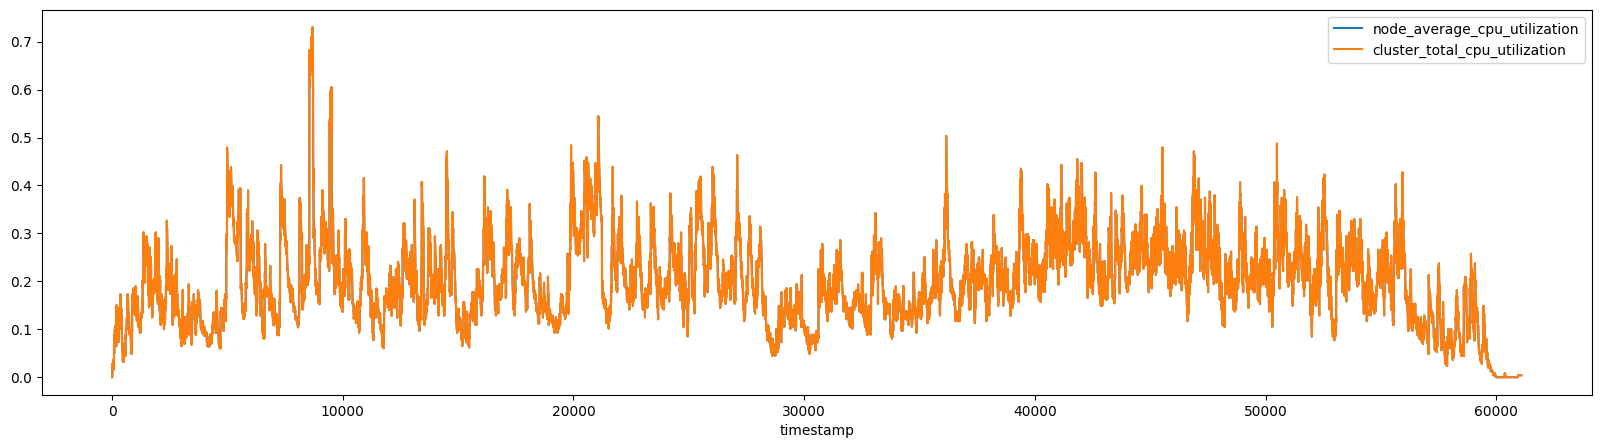

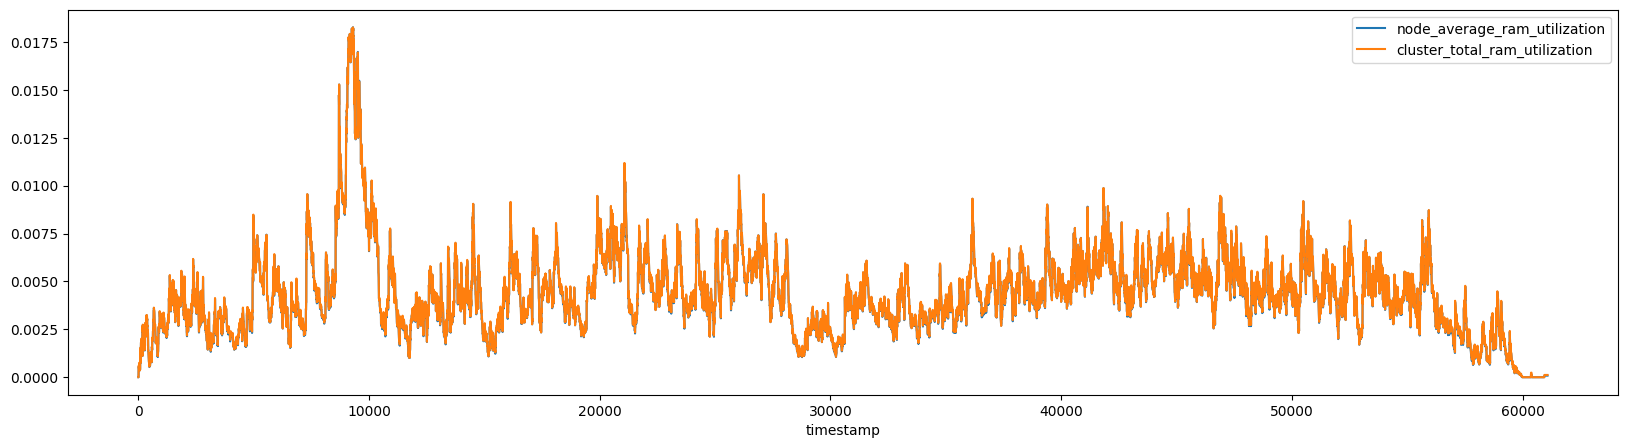

In [18]:
sim_metrics = pd.read_csv('gauge_metrics.csv')
sim_metrics.describe()
sim_metrics.plot(x='timestamp', y=['current_nodes', "current_pods"], figsize=(20,5))
sim_metrics.plot(x='timestamp', y=['pods_in_scheduling_queues'], figsize=(20,5))
sim_metrics.plot(x='timestamp', y=['node_average_cpu_utilization', "cluster_total_cpu_utilization"], figsize=(20,5))
sim_metrics.plot(x='timestamp', y=['node_average_ram_utilization', "cluster_total_ram_utilization"], figsize=(20,5))
